# 모델 이름

In [1]:
model_name = 'model_OD3'

# 준비

In [2]:
import os                           # 운영체제
import time                         # 시간
import tensorflow as tf             # 텐서플로
import pandas as pd                 # 판다스
import matplotlib.pyplot as plt     # 그래프 도구
import MSRL                         # Musical Symbol Recognition Library

c:\Users\chorokmoo_win\.conda\envs\new2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\chorokmoo_win\.conda\envs\new2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issu

In [3]:
# 사용 가능한 모든 GPU 리스트
gpus = tf.config.list_physical_devices('GPU')

# 사용할 프로세서 선택 : GPU
if gpus:
    try: tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e: print(e)

In [4]:
# 모델 주소
model_dir = os.path.join('.', 'models', model_name+'.h5')
model_epoch_dir = os.path.join('.', 'models', model_name+'-{epoch}.h5')
tensorboard_dir = os.path.join('.', 'model_TB', model_name, time.strftime("%Y_%m_%d-%H_%M_%S"))

In [5]:
# 데이터셋
msDataset = MSRL.datasets.MusicalSymbolDataset()
ds_train, ds_validation, ds_test = msDataset.ds_OD()

# 모델
msModel = MSRL.models.MusicalSymbolModel()

# 콜백 함수
cb_checkpoint_OD = tf.keras.callbacks.ModelCheckpoint(model_epoch_dir, monitor='loss', save_best_only=True)
cb_early_stop_OD = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=False)
cb_tensorboard_OD = tf.keras.callbacks.TensorBoard(tensorboard_dir)

-- TFDS Train ------------------
input  : (20000,), <dtype: 'string'>
output : (20000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 20000
number of each class : [20000, 20000, 12451, 9883, 11304, 7421, 9873, 12310, 10638, 11838]

-- TFDS Validation ------------------
input  : (2000,), <dtype: 'string'>
output : (2000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 2000
number of each class : [2000, 2000, 1250, 1015, 1105, 733, 1006, 1276, 1101, 1191]

-- TFDS Test ------------------
input  : (2000,), <dtype: 'string'>
output : (2000, 70), <dtype: 'int16'>
---------------------------------
total number of labels : 2000
number of each class : [2000, 2000, 1222, 987, 1081, 795, 993, 1223, 1067, 1167]



# 모델 학습

In [6]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 생성
    model = msModel.model_OD3() 

    # 모델 컴파일 설정
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=MSRL.losses.WeightedMultiTaskLoss(20000, [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722]),
        metrics=[
            MSRL.metrics.Accuracy(),                # 정확도
            MSRL.metrics.HammingScore(),            # 해밍 점수
            MSRL.metrics.IoU(512, 192),             # IoU 점수 평균
            MSRL.metrics.PointDistance(512, 192)    # 중심 좌표 차이
        ]
    )

    # 모델 훈련
    history = model.fit(
        ds_train,
        epochs=20,
        initial_epoch=0,
        validation_data=ds_validation,
        callbacks=[cb_checkpoint_OD, cb_early_stop_OD, cb_tensorboard_OD]
    )

    # 현재까지 학습된 모델 저장
    model.save(model_dir)

# 텐서보드 확인
# tensorboard.exe --logdir=.\model_TB\model_OD --port=6006

Epoch 1/20
625/625 [==============================] - 280s 347ms/step - loss: 15.1847 - Accuracy: 0.2755 - HammingScore: 0.7764 - IoU: 9.6460e-04 - PointDistance: 110.0675 - val_loss: 18.9524 - val_Accuracy: 0.2285 - val_HammingScore: 0.7947 - val_IoU: 1.2981e-05 - val_PointDistance: 109.2714
Epoch 2/20
625/625 [==============================] - 191s 306ms/step - loss: 9.0116 - Accuracy: 0.3400 - HammingScore: 0.8277 - IoU: 1.1283e-04 - PointDistance: 109.6351 - val_loss: 9.8079 - val_Accuracy: 0.3110 - val_HammingScore: 0.7845 - val_IoU: 4.6023e-05 - val_PointDistance: 110.2767
Epoch 3/20
625/625 [==============================] - 205s 329ms/step - loss: 60.1783 - Accuracy: 0.1991 - HammingScore: 0.7152 - IoU: 0.0026 - PointDistance: 117.9804 - val_loss: 94.7765 - val_Accuracy: 0.0945 - val_HammingScore: 0.6230 - val_IoU: 0.0084 - val_PointDistance: 112.0654
Epoch 4/20
625/625 [==============================] - 196s 313ms/step - loss: 90.5898 - Accuracy: 0.0997 - HammingScore: 0.6341 

# 모델 추가 학습

In [6]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 불러오기
    model = tf.keras.models.load_model(model_dir, compile=False)

    # 모델 컴파일 설정
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=MSRL.losses.WeightedMultiTaskLoss(20000, [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722]),
        metrics=[
            MSRL.metrics.Accuracy(),                # 정확도
            MSRL.metrics.HammingScore(),            # 해밍 점수
            MSRL.metrics.IoU(512, 192),             # IoU 점수 평균
            MSRL.metrics.PointDistance(512, 192)    # 중심 좌표 차이
        ]
    )

    # 모델 훈련
    history = model.fit(
        ds_train,
        epochs=40,
        initial_epoch=20,
        validation_data=ds_validation,
        callbacks=[cb_checkpoint_OD, cb_early_stop_OD, cb_tensorboard_OD]
    )

    # 현재까지 학습된 모델 저장
    model.save(model_dir)

# 텐서보드 확인
# tensorboard.exe --logdir=.\model_TB\model_OD --port=6006

Epoch 21/40
625/625 [==============================] - 277s 348ms/step - loss: 1.5349 - Accuracy: 0.8460 - HammingScore: 0.9839 - IoU: 0.5137 - PointDistance: 16.9525 - val_loss: 1.5981 - val_Accuracy: 0.8575 - val_HammingScore: 0.9852 - val_IoU: 0.4488 - val_PointDistance: 20.4987
Epoch 22/40
625/625 [==============================] - 249s 399ms/step - loss: 1.2576 - Accuracy: 0.8821 - HammingScore: 0.9877 - IoU: 0.5363 - PointDistance: 15.6072 - val_loss: 1.4391 - val_Accuracy: 0.8585 - val_HammingScore: 0.9853 - val_IoU: 0.5075 - val_PointDistance: 15.8555
Epoch 23/40
625/625 [==============================] - 177s 283ms/step - loss: 1.1900 - Accuracy: 0.8996 - HammingScore: 0.9896 - IoU: 0.5345 - PointDistance: 15.4893 - val_loss: 1.5625 - val_Accuracy: 0.8445 - val_HammingScore: 0.9834 - val_IoU: 0.5089 - val_PointDistance: 17.1327
Epoch 24/40
625/625 [==============================] - 198s 317ms/step - loss: 1.1422 - Accuracy: 0.9128 - HammingScore: 0.9910 - IoU: 0.5323 - PointDi

# 학습 결과

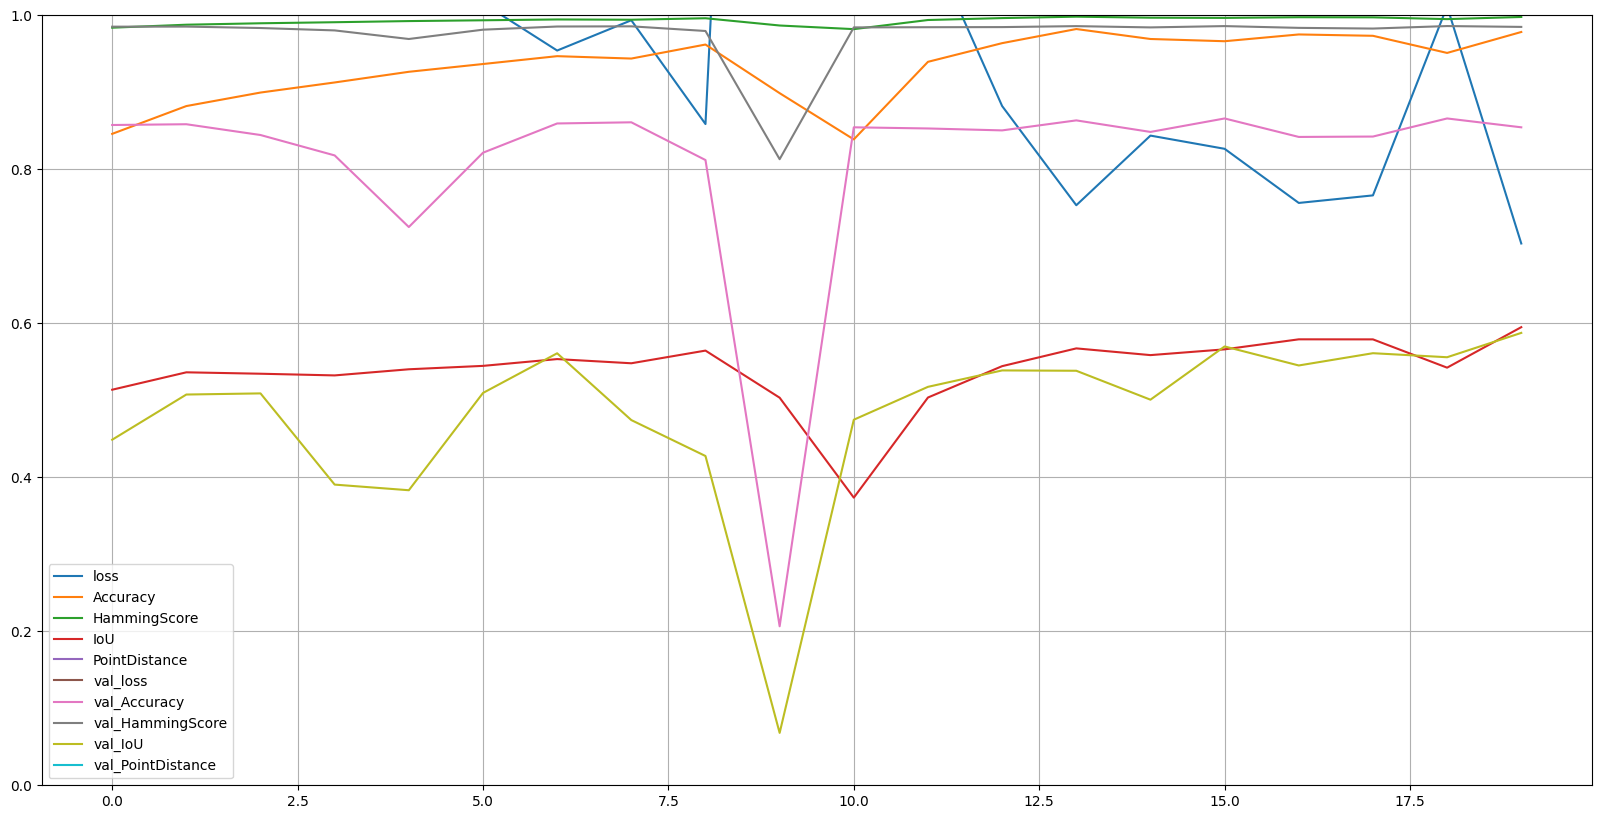

In [7]:
# model_YOLO 훈련 결과 그리기
pd.DataFrame(history.history).plot(figsize=(20, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()